# Analysis of integrating multiple "-omic" datasets from ATAC-STARR

## Introduction

We generated activity, accessibility, and footprinting results from a single ATAC-STARR library. We now want to integrate this information to better investigate gene regulatory regions. 

## Cluster regulatory regions by TF footprint

### Score regions based on presence or absence of a footprint

In [1]:
%%bash
# Output a BED6+ file with a 0 or 1 score in its 7th column representing the absence or presence of a TF motif, respectively. 

#Path Varialbes
ACTIVE='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed'
TF_PATH='/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05'
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering'

#Active
#Assign a score of 1 to regions with the footprint and 0 to the regions without a footprint for each TF analyzed. Join all TFs in R. 
#Loop through TFs: 
for TF in IRF4_MA1419.1 ELK1_MA0028.2 NFKB1_MA0105.4 JUNB_MA0490.2 SPI1_MA0080.5 BACH2_MA1101.2 
do
    #-u will report a region if an overlap exists. Add a 1 to these regions in a new column. 
    bedtools intersect -u -a $ACTIVE -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk '{OFS=FS="\t"}; BEGIN{print "Chr","Start","End","Peak_ID","Score","Strand",$TF};{print $0,"1"}' - > \
        ${OUTPUT_DIR}/${TF}_tmp-u.bed
        
    #-v will report a region if no overlap exists. Add a 0 to these regions in a new column.  
    bedtools intersect -v -a $ACTIVE -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk 'BEGIN{OFS=FS="\t"}{print $0,"0"}' - > ${OUTPUT_DIR}/${TF}_tmp-v.bed
        
    #concatenate theses files and sort. Regions should only exist in either tmp-u or tmp-v not both. Thus the number of lines in the output should equal the number of lines in the input. 
    cat ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed | sort -k1,1 -k2,2n - > \
        ${OUTPUT_DIR}/${TF}-in-GM12878inGM12878_active.bed
        
    rm ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed
done

In [2]:
%%bash
# Output a BED6+ file with a 0 or 1 score in its 7th column representing the absence or presence of a TF motif, respectively. 

#Path Varialbes
SILENT='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/silent_regions.bed'
TF_PATH='/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05'
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering'

#Active
#Assign a score of 1 to regions with the footprint and 0 to the regions without a footprint for each TF analyzed. Join all TFs in R. 
#Loop through TFs: 
for TF in ZBTB7A_MA0750.2 NFYA_MA0060.3 SP1_MA0079.4 CTCF_MA0139.1
do
    #-u will report a region if an overlap exists. Add a 1 to these regions in a new column. 
    bedtools intersect -u -a $SILENT -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk '{OFS=FS="\t"}; BEGIN{print "Chr","Start","End","Peak_ID","Score","Strand",$TF};{print $0,"1"}' - > \
        ${OUTPUT_DIR}/${TF}_tmp-u.bed
        
    #-v will report a region if no overlap exists. Add a 0 to these regions in a new column.  
    bedtools intersect -v -a $SILENT -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk 'BEGIN{OFS=FS="\t"}{print $0,"0"}' - > ${OUTPUT_DIR}/${TF}_tmp-v.bed
        
    #concatenate theses files and sort. Regions should only exist in either tmp-u or tmp-v not both. Thus the number of lines in the output should equal the number of lines in the input. 
    cat ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed | sort -k1,1 -k2,2n - > \
        ${OUTPUT_DIR}/${TF}-in-GM12878inGM12878_silent.bed
        
    rm ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed
done

### Cluster regions based on TF score and plot heatmap

In [2]:
library(tidyverse)
library(pheatmap)
library(viridis)
set.seed(123)
library(ggsci)
library(ChIPseeker)
library(clusterProfiler)
library("GenomicRanges")
library(org.Hs.eg.db)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(ReactomePA)

Loading required package: viridisLite



ChIPseeker v1.28.3  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383

clusterProfiler v4.0.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Att

#### Active

In [3]:
#Read in results and sort by peak_ID for all
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering/'

IRF <- read_tsv(paste0(dir,"IRF4_MA1419.1-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","IRF")) %>% arrange(Peak_ID)

SPI <- read_tsv(paste0(dir,"SPI1_MA0080.5-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","SPI")) %>% arrange(Peak_ID)

CREB <- read_tsv(paste0(dir,"JUNB_MA0490.2-in-GM12878inGM12878_active.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","CREB")) %>% arrange(Peak_ID)

NFKB <- read_tsv(paste0(dir,"NFKB1_MA0105.4-in-GM12878inGM12878_active.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","NFKB")) %>% arrange(Peak_ID)

AP1 <- read_tsv(paste0(dir,"BACH2_MA1101.2-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","AP1")) %>% arrange(Peak_ID) 

ETS <- read_tsv(paste0(dir,"ELK1_MA0028.2-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","ETS")) %>% arrange(Peak_ID)


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col_double(),
  Strand = col_character(),
  IRF = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col_double(),
  Strand = col_character(),
  SPI = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col_double(),
  Strand = col_character(),
  CREB = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col_do

In [4]:
#cbind each TF together. Since Peak_ID order is the same for all, only need to join TF column. 
active <- cbind(IRF, SPI = SPI$SPI, CREB = CREB$CREB, NFKB = NFKB$NFKB, AP1 = AP1$AP1, ETS = ETS$ETS)

#Convert to matrix
active_matrix <- column_to_rownames(active, var = "Peak_ID") %>% dplyr::select(-chr, -start, -end, -Score, -Strand)

#Remove all regions without a footprint. 
active_matrix_subset <- filter(active_matrix, rowSums(active_matrix) != 0)

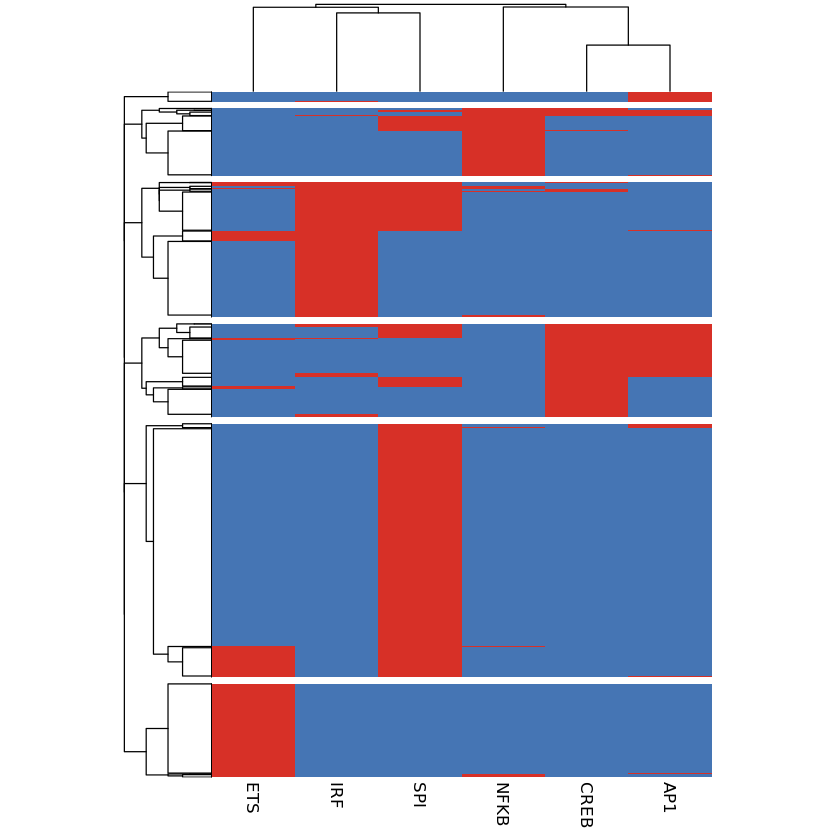

In [45]:
#Heatmap
heatmap <- pheatmap(active_matrix_subset, show_rownames = FALSE, cluster_cols=TRUE, cluster_rows=TRUE, 
                    cellwidth = 50, cutree_rows = 6, display_numbers = FALSE, legend = FALSE, 
                    clustering_distance_rows = 'binary', clustering_distance_cols = 'binary')

In [32]:
pdf("/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/multiomic_heatmap.pdf", width=6, height=8)
heatmap
dev.off()

png 
  2

In [46]:
#Assign cluster number to each region. cbind cluster to the input matrix and then left_join with df to get genomic coordinates.  
active_cluster <- cbind(active_matrix_subset, Cluster = cutree(heatmap$tree_row,k = 6)) %>% 
    rownames_to_column(var = "Peak_ID") %>% 
    left_join(active, by = c("Peak_ID", "IRF", "SPI", "CREB", "NFKB", "AP1", "ETS")) %>% 
    dplyr::select(chr, start, end, Peak_ID, Cluster, IRF, SPI, CREB, NFKB, AP1, ETS)

#split into 6 clusters. 
SPI_clust <- filter(active_cluster, Cluster == 1)
ETS_clust <- filter(active_cluster, Cluster == 2)
AP1_CREB_clust <- filter(active_cluster, Cluster == 3)
IRF_clust <- filter(active_cluster, Cluster == 4)
NFKB_clust <- filter(active_cluster, Cluster == 5)
AP1_clust <- filter(active_cluster, Cluster == 6)

In [47]:
#Verify I selected the correct cluster
head(SPI_clust)
head(ETS_clust)
head(AP1_CREB_clust)
head(IRF_clust)
head(NFKB_clust)
head(AP1_clust)

,chr,start,end,Peak_ID,Cluster,IRF,SPI,CREB,NFKB,AP1,ETS
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr15,85253442,85253782,region_10002,1,0,1,0,0,0,0
2,chr15,85329836,85330166,region_10008,1,0,1,0,0,0,0
3,chr15,90059679,90059739,region_10061,1,0,1,0,0,0,0
4,chr15,90059749,90059799,region_10062,1,0,1,0,0,0,0
5,chr15,90191631,90191931,region_10066,1,0,1,0,0,0,0
6,chr15,90265632,90265862,region_10072,1,0,1,0,0,0,1


,chr,start,end,Peak_ID,Cluster,IRF,SPI,CREB,NFKB,AP1,ETS
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr15,85331219,85331299,region_10009,2,0,0,0,0,0,1
2,chr15,88621224,88621384,region_10028,2,0,0,0,0,0,1
3,chr15,89894024,89894174,region_10058,2,0,0,0,0,0,1
4,chr16,1420760,1420920,region_10225,2,0,0,0,0,0,1
5,chr16,1773058,1773198,region_10237,2,0,0,0,0,0,1
6,chr16,2751959,2752129,region_10280,2,0,0,0,0,0,1


,chr,start,end,Peak_ID,Cluster,IRF,SPI,CREB,NFKB,AP1,ETS
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr15,88638599,88638939,region_10031,3,0,0,1,0,0,0
2,chr15,90845212,90845332,region_10091,3,0,0,1,0,1,0
3,chr15,90852746,90852836,region_10092,3,0,0,1,0,0,0
4,chr15,92644023,92644143,region_10115,3,0,0,1,0,1,0
5,chr15,99502176,99502266,region_10156,3,0,0,1,0,1,0
6,chr15,99502316,99502386,region_10157,3,0,0,1,0,0,0


,chr,start,end,Peak_ID,Cluster,IRF,SPI,CREB,NFKB,AP1,ETS
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr15,88639949,88640339,region_10033,4,1,1,0,0,0,0
2,chr15,90149188,90149398,region_10063,4,1,0,0,0,0,0
3,chr15,99090600,99090690,region_10149,4,1,0,0,0,0,0
4,chr15,99452927,99453237,region_10154,4,1,1,0,0,0,0
5,chr15,101127535,101127645,region_10184,4,1,0,0,0,0,0
6,chr16,1331772,1331822,region_10221,4,1,0,0,0,0,0


,chr,start,end,Peak_ID,Cluster,IRF,SPI,CREB,NFKB,AP1,ETS
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr15,92809549,92809669,region_10119,5,0,0,0,1,0,0
2,chr15,99433415,99433615,region_10153,5,0,0,0,1,0,0
3,chr15,100941537,100941677,region_10177,5,0,0,0,1,0,0
4,chr16,611266,611396,region_10208,5,0,0,0,1,0,0
5,chr16,11225494,11226054,region_10424,5,0,1,0,1,0,0
6,chr16,21952693,21953153,region_10562,5,0,0,0,1,0,0


,chr,start,end,Peak_ID,Cluster,IRF,SPI,CREB,NFKB,AP1,ETS
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr16,8891497,8891767,region_10358,6,0,0,0,0,1,0
2,chr16,27431155,27431205,region_10625,6,0,0,0,0,1,0
3,chr16,31094910,31095090,region_10745,6,0,0,0,0,1,0
4,chr16,53098869,53098999,region_10837,6,0,0,0,0,1,0
5,chr16,75109029,75109179,region_11120,6,0,0,0,0,1,0
6,chr16,87779082,87779182,region_11332,6,0,0,0,0,1,0


In [48]:
#how many total?
nrow(active_cluster)
#how many in each cluster?
nrow(SPI_clust)
nrow(ETS_clust)
nrow(AP1_CREB_clust)
nrow(IRF_clust)
nrow(NFKB_clust)
nrow(AP1_clust)

[1] 4200

[1] 1632

[1] 603

[1] 600

[1] 867

[1] 434

[1] 64

#### Active clusters pathway enrichment

In [35]:
#make gRanges object and annotate peaks to assign nearest neighbor. 
ETS_anno <- annotatePeak(with(ETS_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                         TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

IRF_anno <- annotatePeak(with(IRF_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                         TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

SPI_anno <- annotatePeak(with(SPI_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                         TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

AP1_CREB_anno <- annotatePeak(with(AP1_CREB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                              TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

NFKB_anno <- annotatePeak(with(NFKB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                          TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

AP1_anno <- annotatePeak(with(AP1_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                          TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

>> preparing features information...		 2021-11-15 09:43:04 AM 
>> identifying nearest features...		 2021-11-15 09:43:04 AM 
>> calculating distance from peak to TSS...	 2021-11-15 09:43:04 AM 
>> assigning genomic annotation...		 2021-11-15 09:43:04 AM 
>> adding gene annotation...			 2021-11-15 09:43:09 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 09:43:10 AM 
>> done...					 2021-11-15 09:43:10 AM 
>> preparing features information...		 2021-11-15 09:43:10 AM 
>> identifying nearest features...		 2021-11-15 09:43:10 AM 
>> calculating distance from peak to TSS...	 2021-11-15 09:43:10 AM 
>> assigning genomic annotation...		 2021-11-15 09:43:10 AM 
>> adding gene annotation...			 2021-11-15 09:43:15 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 09:43:15 AM 
>> done...					 2021-11-15 09:43:15 AM 
>> preparing features information...		 2021-11-15 09:43:15 AM 
>> identifying nearest features...		 2021-11-15 09:43:15 AM 
>> calculating distance from peak to TSS...	 2021-11-15 09:43:16 AM 
>> assigning genomic annotation...		 2021-11-15 09:43:16 AM 
>> adding gene annotation...			 2021-11-15 09:43:22 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 09:43:22 AM 
>> done...					 2021-11-15 09:43:22 AM 
>> preparing features information...		 2021-11-15 09:43:22 AM 
>> identifying nearest features...		 2021-11-15 09:43:22 AM 
>> calculating distance from peak to TSS...	 2021-11-15 09:43:23 AM 
>> assigning genomic annotation...		 2021-11-15 09:43:23 AM 
>> adding gene annotation...			 2021-11-15 09:43:27 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 09:43:27 AM 
>> done...					 2021-11-15 09:43:27 AM 
>> preparing features information...		 2021-11-15 09:43:27 AM 
>> identifying nearest features...		 2021-11-15 09:43:28 AM 
>> calculating distance from peak to TSS...	 2021-11-15 09:43:28 AM 
>> assigning genomic annotation...		 2021-11-15 09:43:28 AM 
>> adding gene annotation...			 2021-11-15 09:43:33 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 09:43:33 AM 
>> done...					 2021-11-15 09:43:33 AM 
>> preparing features information...		 2021-11-15 09:43:33 AM 
>> identifying nearest features...		 2021-11-15 09:43:33 AM 
>> calculating distance from peak to TSS...	 2021-11-15 09:43:34 AM 
>> assigning genomic annotation...		 2021-11-15 09:43:34 AM 
>> adding gene annotation...			 2021-11-15 09:43:39 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 09:43:39 AM 
>> done...					 2021-11-15 09:43:39 AM 


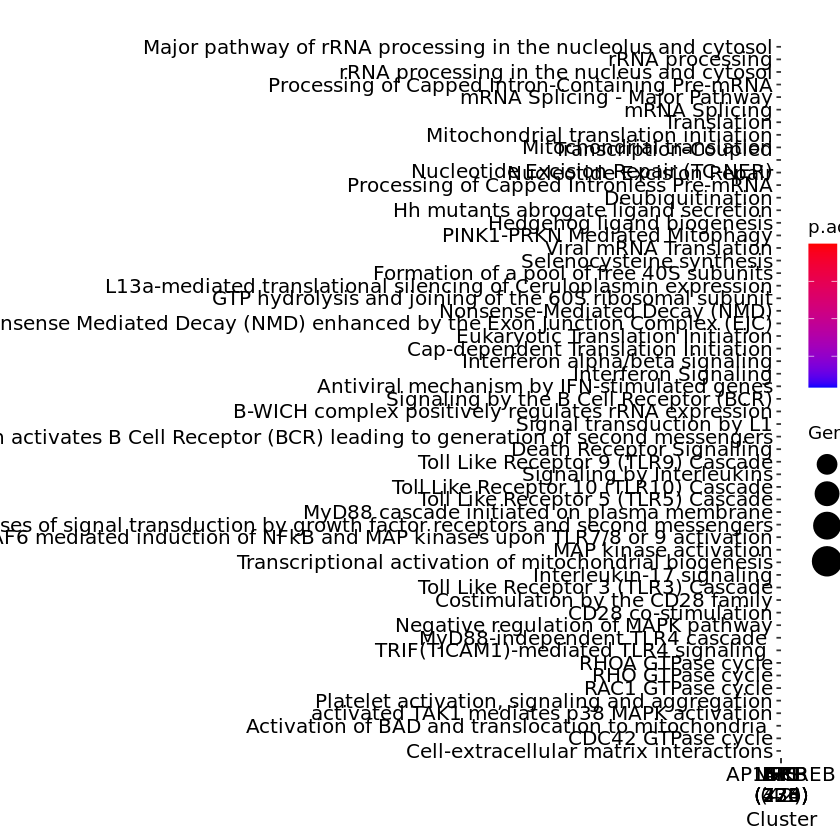

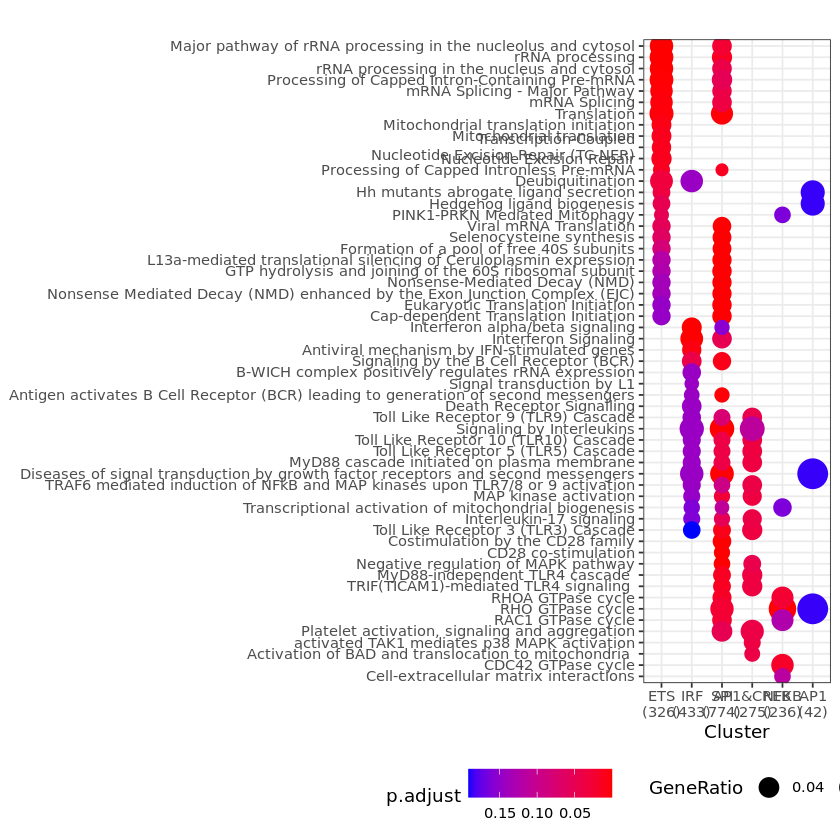

In [58]:
#perform reactome pathway enrichment analysis of nearest neighbor gene sets. Make list of genes first. Then run on all simultaneously with clusterProfiler
gene_list <- list(ETS = as.data.frame(ETS_anno)$geneId, IRF = as.data.frame(IRF_anno)$geneId, 
                  SPI = as.data.frame(SPI_anno)$geneId, `AP1&CREB` = as.data.frame(AP1_CREB_anno)$geneId, 
                  NFKB = as.data.frame(NFKB_anno)$geneId, AP1 = as.data.frame(AP1_anno)$geneId)

reactome_results <- compareCluster(gene_list, fun = "enrichPathway", pvalueCutoff = 0.2)

dotplot(reactome_results, showCategory = 12) + theme_bw() + theme(legend.position = "bottom")

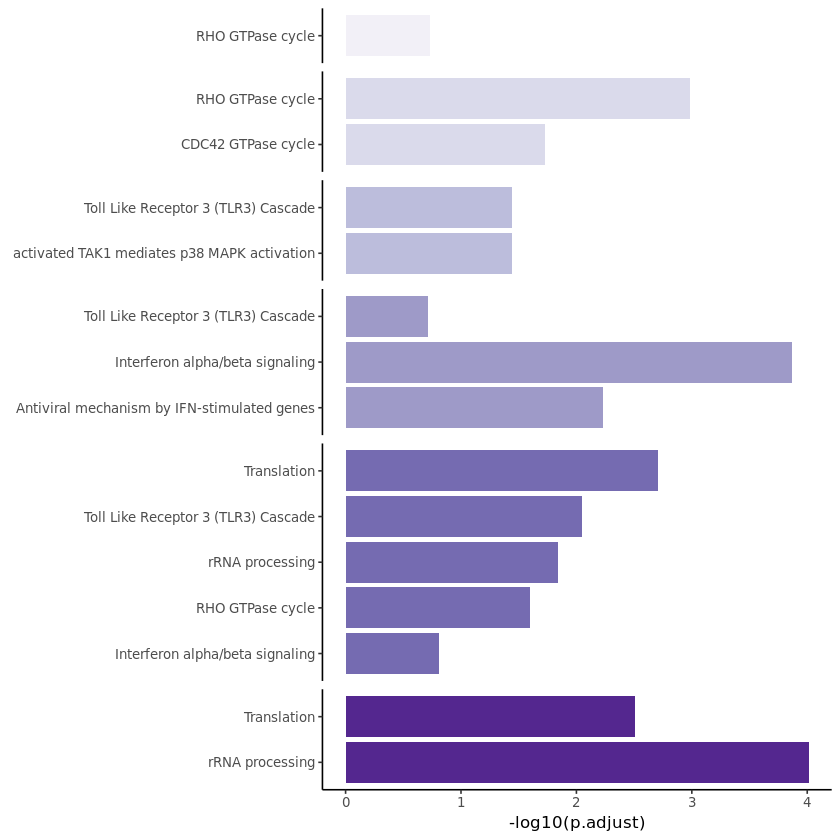

In [67]:
#Rather than showing dotplot, which is clunky, make a column plot of p.adj for select pathways. 
res_df <- as.data.frame(reactome_results) 
filtered_df <- dplyr::filter(res_df, Description == "TRIF(TICAM1)-mediated TLR4 signaling")
filtered_df <- dplyr::filter(res_df, Description == "RHO GTPase cycle") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "Toll Like Receptor 3 (TLR3) Cascade") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "Interferon alpha/beta signaling") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "Antiviral mechanism by IFN-stimulated genes") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "activated TAK1 mediates p38 MAPK activation") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "rRNA processing") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "Translation") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "CDC42 GTPase cycle") %>% bind_rows(filtered_df)
filtered_df$Cluster <- factor(filtered_df$Cluster, levels = c("AP1", "NFKB", "AP1&CREB", "IRF", "SPI",  "ETS")) 

p <- ggplot(filtered_df, aes(y=Description, x=-log10(p.adjust))) + 
  geom_col(orientation = "y", aes(fill = Cluster)) + 
  facet_grid(Cluster~., space = "free_y", scales = "free_y") + 
  theme_classic(base_size = 10, base_family = "Arial") + 
  scale_fill_brewer(palette = "Purples") +
  theme(strip.text = element_blank(), axis.title.y = element_blank(), legend.position = "none")

p

In [68]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/reactome-bar.pdf", 
       device = cairo_pdf, width = 6, height = 6)

#### Silent

In [69]:
#Read in results and sort by peak_ID for all
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering/'

CTCF <- read_tsv(paste0(dir,"CTCF_MA0139.1-in-GM12878inGM12878_silent.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","CTCF")) %>% arrange(Peak_ID)

SP1 <- read_tsv(paste0(dir,"SP1_MA0079.4-in-GM12878inGM12878_silent.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","SP1")) %>% arrange(Peak_ID)

ZBTB7A <- read_tsv(paste0(dir,"ZBTB7A_MA0750.2-in-GM12878inGM12878_silent.bed"), skip = 1, 
                   col_names = c("chr","start","end","Peak_ID","Score","Strand","ZBTB7A")) %>% arrange(Peak_ID)

NFYA <- read_tsv(paste0(dir,"NFYA_MA0060.3-in-GM12878inGM12878_silent.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","NFYA")) %>% arrange(Peak_ID)


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col_double(),
  Strand = col_character(),
  CTCF = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col_double(),
  Strand = col_character(),
  SP1 = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col_double(),
  Strand = col_character(),
  ZBTB7A = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Peak_ID = col_character(),
  Score = col

In [70]:
#cbind each TF together. Since Peak_ID order is the same for all, only need to join TF column. 
silent <- cbind(CTCF, SP1 = SP1$SP1, ZBTB7A = ZBTB7A$ZBTB7A, NFYA = NFYA$NFYA)

#Convert to matrix
silent_matrix <- column_to_rownames(silent, var = "Peak_ID") %>% dplyr::select(-chr, -start, -end, -Score, -Strand)

#Remove all regions without a footprint. 
silent_matrix_subset <- filter(silent_matrix, rowSums(silent_matrix) != 0)

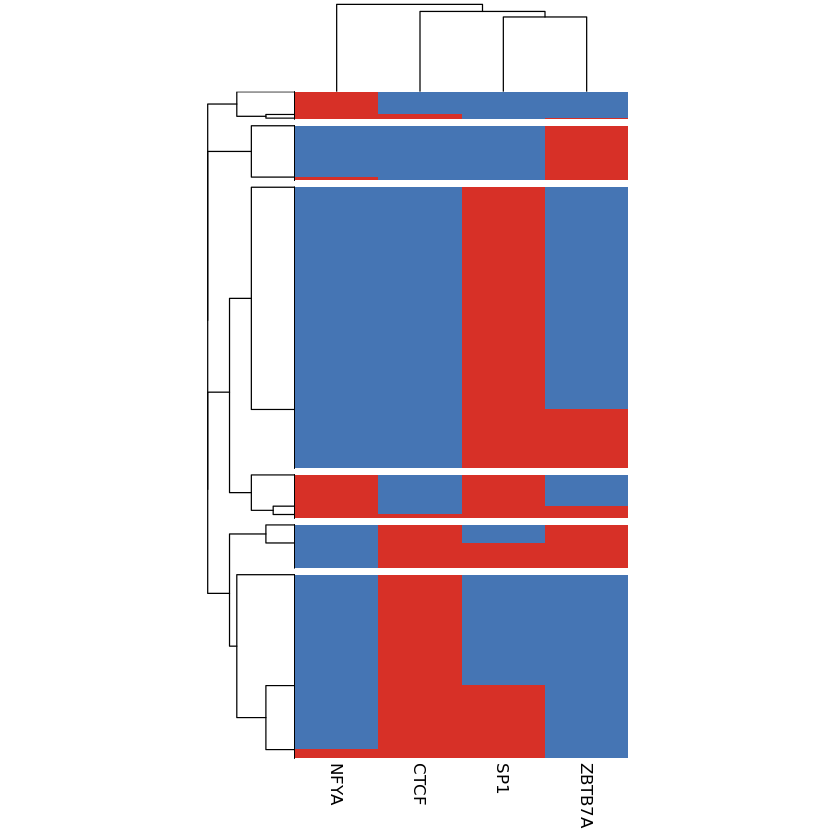

In [76]:
#Heatmap
heatmap <- pheatmap(silent_matrix_subset, show_rownames = FALSE, cluster_cols=TRUE, cluster_rows=TRUE, 
                    cellwidth = 50, cutree_rows = 6, display_numbers = FALSE, legend = FALSE, 
                    clustering_distance_rows = 'binary', clustering_distance_cols = 'binary')

In [77]:
pdf("/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/multiomic_heatmap_silent.pdf", width=6, height=8)
heatmap
dev.off()

png 
  2

In [81]:
#Assign cluster number to each region. cbind cluster to the input matrix and then left_join with df to get genomic coordinates.  
silent_cluster <- cbind(silent_matrix_subset, Cluster = cutree(heatmap$tree_row,k = 6)) %>% rownames_to_column(var = "Peak_ID") %>% 
    left_join(silent, by = c("Peak_ID", "NFYA", "CTCF", "SP1", "ZBTB7A")) %>% 
    dplyr::select(chr, start, end, Peak_ID, Cluster, NFYA, CTCF, SP1, ZBTB7A)

#split into 6 clusters. 
SP1_clust <- filter(silent_cluster, Cluster == 1)
CTCF_SP1_clust <- filter(silent_cluster, Cluster == 2)
SP1_NFYA_clust <- filter(silent_cluster, Cluster == 3)
CTCF_SP1_ZBTB_clust <- filter(silent_cluster, Cluster == 4)
ZBTB_clust <- filter(silent_cluster, Cluster == 5)
NFYA_clust <- filter(silent_cluster, Cluster == 6)

In [82]:
#Verify I selected the correct cluster
head(SP1_clust)
head(CTCF_SP1_clust)
head(SP1_NFYA_clust)
head(CTCF_SP1_ZBTB_clust)
head(ZBTB_clust)
head(NFYA_clust)

,chr,start,end,Peak_ID,Cluster,NFYA,CTCF,SP1,ZBTB7A
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,827584,827814,region_1,1,0,0,1,0
2,chr1,1918875,1919515,region_100,1,0,0,1,0
3,chr19,7920387,7920617,region_10000,1,0,0,1,0
4,chr19,7920697,7920897,region_10001,1,0,0,1,0
5,chr19,8050702,8050762,region_10010,1,0,0,1,0
6,chr19,8209050,8209970,region_10013,1,0,0,1,0


,chr,start,end,Peak_ID,Cluster,NFYA,CTCF,SP1,ZBTB7A
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,76154280,76154390,region_1000,2,0,1,0,0
2,chr19,7926049,7926319,region_10003,2,0,1,1,0
3,chr19,8412921,8413281,region_10022,2,0,1,1,0
4,chr19,9796272,9796462,region_10043,2,0,1,0,0
5,chr19,10096065,10096205,region_10053,2,0,1,1,0
6,chr19,10416442,10416712,region_10068,2,0,1,0,0


,chr,start,end,Peak_ID,Cluster,NFYA,CTCF,SP1,ZBTB7A
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr19,8005526,8006016,region_10008,3,1,0,1,1
2,chr19,8832853,8833113,region_10036,3,1,0,1,0
3,chr19,9835019,9835359,region_10047,3,1,0,1,0
4,chr19,10695802,10696062,region_10088,3,1,0,1,0
5,chr19,11597267,11597397,region_10122,3,1,0,1,0
6,chr19,11639671,11639761,region_10125,3,1,0,1,0


,chr,start,end,Peak_ID,Cluster,NFYA,CTCF,SP1,ZBTB7A
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,77683173,77683593,region_1002,4,0,1,0,1
2,chr19,12757649,12758049,region_10166,4,0,1,0,1
3,chr19,13847750,13848020,region_10215,4,0,1,1,1
4,chr19,14405928,14406448,region_10245,4,0,1,1,1
5,chr19,18161087,18161587,region_10375,4,0,1,1,1
6,chr19,18433230,18433670,region_10398,4,0,1,0,1


,chr,start,end,Peak_ID,Cluster,NFYA,CTCF,SP1,ZBTB7A
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr19,8832083,8832353,region_10035,5,0,0,0,1
2,chr19,10194656,10194896,region_10057,5,0,0,0,1
3,chr19,10430611,10430881,region_10072,5,0,0,0,1
4,chr19,10502751,10503371,region_10078,5,0,0,0,1
5,chr1,84077749,84078139,region_1014,5,0,0,0,1
6,chr19,12139926,12140136,region_10144,5,0,0,0,1


,chr,start,end,Peak_ID,Cluster,NFYA,CTCF,SP1,ZBTB7A
,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr19,10288806,10288876,region_10061,6,1,1,0,0
2,chr19,11482132,11482382,region_10112,6,1,0,0,0
3,chr19,12736932,12737032,region_10164,6,1,0,0,0
4,chr19,13795076,13795566,region_10209,6,1,0,0,0
5,chr19,14496400,14496460,region_10255,6,1,0,0,0
6,chr19,14517678,14518248,region_10256,6,1,0,0,0


In [83]:
#how many total?
nrow(silent_cluster)
#how many in each cluster?
nrow(SP1_clust)
nrow(CTCF_SP1_clust)
nrow(SP1_NFYA_clust)
nrow(CTCF_SP1_ZBTB_clust)
nrow(ZBTB_clust)
nrow(NFYA_clust)

[1] 7789

[1] 3456

[1] 2260

[1] 533

[1] 530

[1] 674

[1] 336

#### Silent clusters pathway enrichment

In [84]:
#make gRanges object and annotate peaks to assign nearest neighbor. 
SP1_anno <- annotatePeak(with(SP1_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

CTCF_SP1_anno <- annotatePeak(with(CTCF_SP1_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

SP1_NFYA_anno <- annotatePeak(with(SP1_NFYA_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

CTCF_SP1_ZBTB_anno <- annotatePeak(with(CTCF_SP1_ZBTB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

ZBTB_anno <- annotatePeak(with(ZBTB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

NFYA_anno <- annotatePeak(with(NFYA_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

>> preparing features information...		 2021-11-15 10:41:39 AM 
>> identifying nearest features...		 2021-11-15 10:41:39 AM 
>> calculating distance from peak to TSS...	 2021-11-15 10:41:40 AM 
>> assigning genomic annotation...		 2021-11-15 10:41:40 AM 
>> adding gene annotation...			 2021-11-15 10:41:44 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 10:41:45 AM 
>> done...					 2021-11-15 10:41:45 AM 
>> preparing features information...		 2021-11-15 10:41:45 AM 
>> identifying nearest features...		 2021-11-15 10:41:45 AM 
>> calculating distance from peak to TSS...	 2021-11-15 10:41:45 AM 
>> assigning genomic annotation...		 2021-11-15 10:41:45 AM 
>> adding gene annotation...			 2021-11-15 10:41:50 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 10:41:50 AM 
>> done...					 2021-11-15 10:41:50 AM 
>> preparing features information...		 2021-11-15 10:41:50 AM 
>> identifying nearest features...		 2021-11-15 10:41:50 AM 
>> calculating distance from peak to TSS...	 2021-11-15 10:41:50 AM 
>> assigning genomic annotation...		 2021-11-15 10:41:50 AM 
>> adding gene annotation...			 2021-11-15 10:41:54 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 10:41:55 AM 
>> done...					 2021-11-15 10:41:55 AM 
>> preparing features information...		 2021-11-15 10:41:55 AM 
>> identifying nearest features...		 2021-11-15 10:41:55 AM 
>> calculating distance from peak to TSS...	 2021-11-15 10:41:55 AM 
>> assigning genomic annotation...		 2021-11-15 10:41:55 AM 
>> adding gene annotation...			 2021-11-15 10:42:00 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 10:42:00 AM 
>> done...					 2021-11-15 10:42:00 AM 
>> preparing features information...		 2021-11-15 10:42:00 AM 
>> identifying nearest features...		 2021-11-15 10:42:00 AM 
>> calculating distance from peak to TSS...	 2021-11-15 10:42:00 AM 
>> assigning genomic annotation...		 2021-11-15 10:42:00 AM 
>> adding gene annotation...			 2021-11-15 10:42:04 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 10:42:05 AM 
>> done...					 2021-11-15 10:42:05 AM 
>> preparing features information...		 2021-11-15 10:42:05 AM 
>> identifying nearest features...		 2021-11-15 10:42:05 AM 
>> calculating distance from peak to TSS...	 2021-11-15 10:42:05 AM 
>> assigning genomic annotation...		 2021-11-15 10:42:05 AM 
>> adding gene annotation...			 2021-11-15 10:42:10 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-11-15 10:42:10 AM 
>> done...					 2021-11-15 10:42:10 AM 


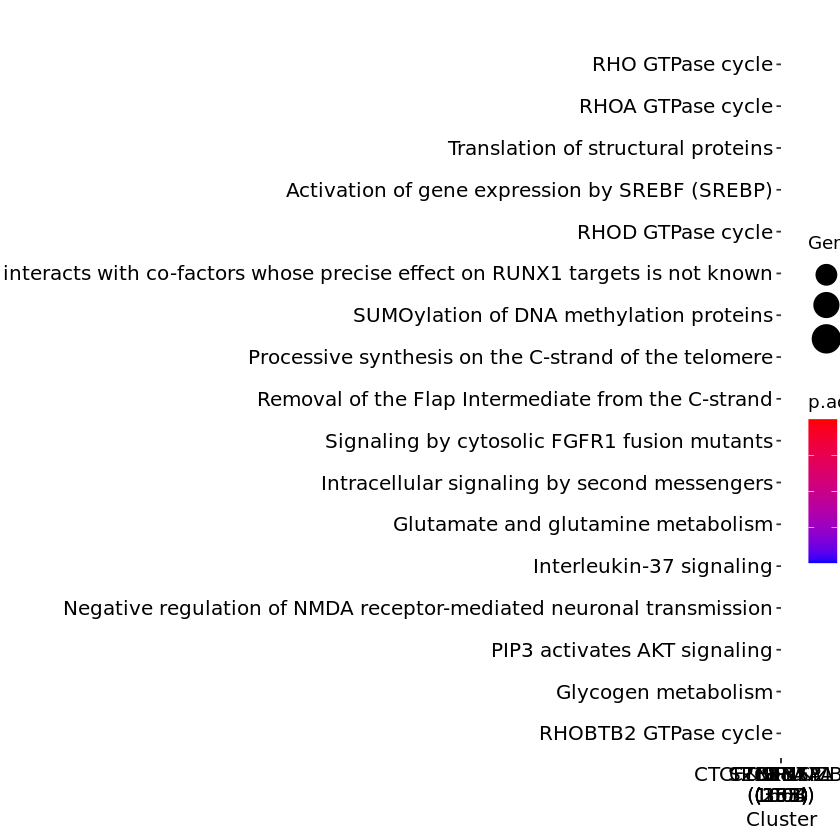

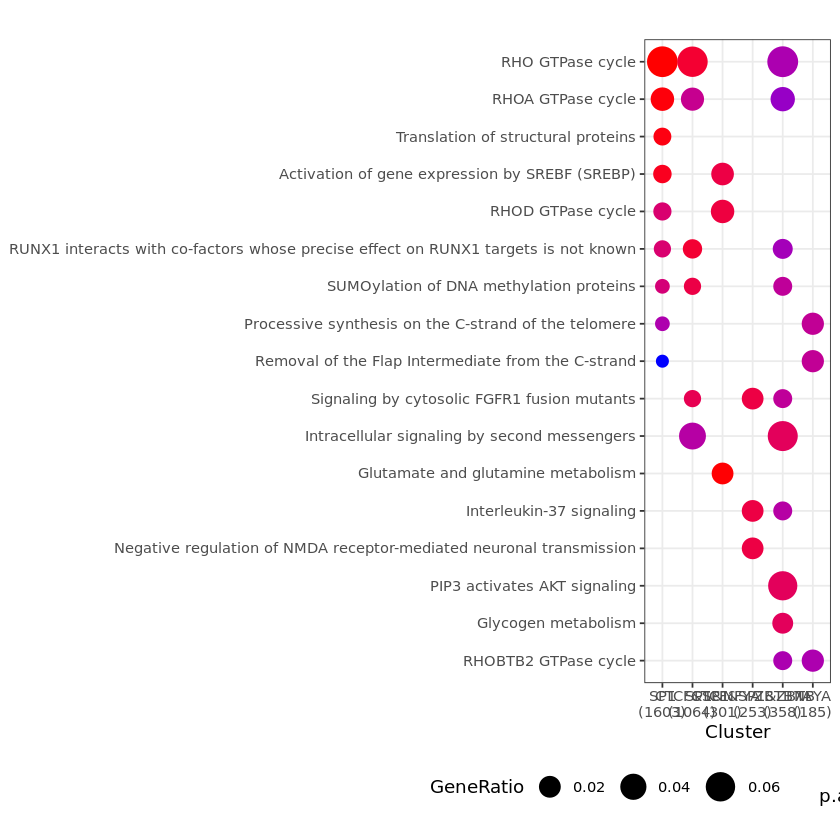

In [106]:
#perform reactome pathway enrichment analysis of nearest neighbor gene sets. Make list of genes first. 
#Then run on all simultaneously with clusterProfiler

silent_gene_list <- list(SP1 = as.data.frame(SP1_anno)$geneId, `CTCF&SP1` = as.data.frame(CTCF_SP1_anno)$geneId, 
                         `SP1&NFYA` = as.data.frame(SP1_NFYA_anno)$geneId, 
                         `CTCF&SP1&ZBTB` = as.data.frame(CTCF_SP1_ZBTB_anno)$geneId, ZBTB7A = as.data.frame(ZBTB_anno)$geneId, 
                         NFYA = as.data.frame(NFYA_anno)$geneId)

silent_reactome_results <- compareCluster(silent_gene_list, fun = "enrichPathway", pvalueCutoff = 0.2)

dotplot(silent_reactome_results, showCategory = 3) + theme_bw() + theme(legend.position = "bottom")

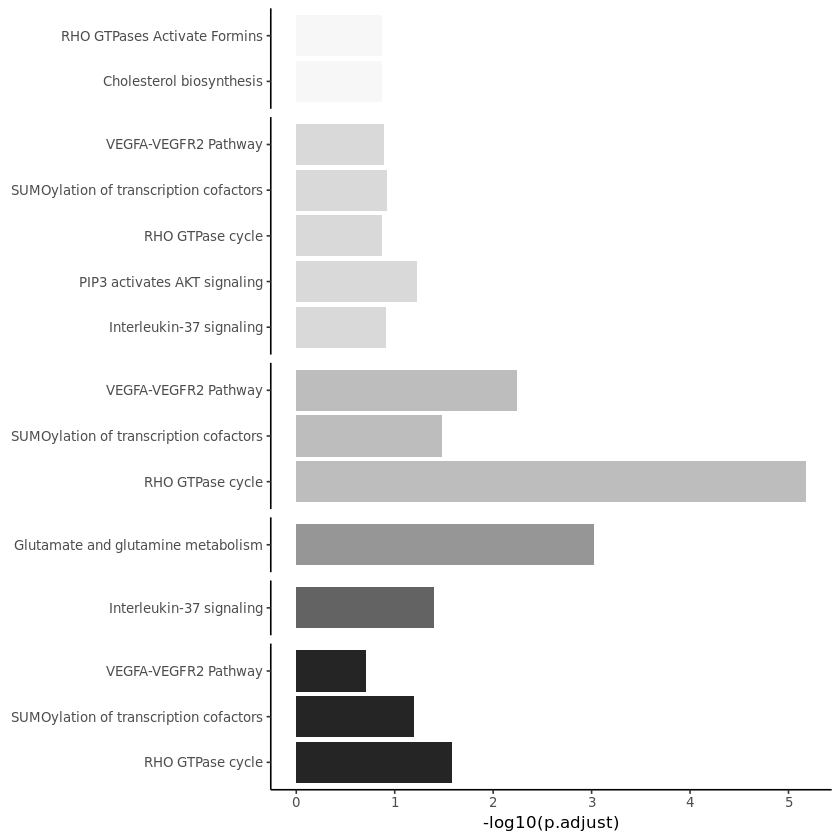

In [112]:
#Rather than showing dotplot, which is clunky, make a column plot of p.adj for select pathways. 
res_df <- as.data.frame(silent_reactome_results) 

filtered_df <- dplyr::filter(res_df, Description == "SUMOylation of transcription cofactors")
filtered_df <- dplyr::filter(res_df, Description == "RHO GTPase cycle") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "VEGFA-VEGFR2 Pathway") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "Glutamate and glutamine metabolism") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "Interleukin-37 signaling") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "PIP3 activates AKT signaling") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "Cholesterol biosynthesis") %>% bind_rows(filtered_df)
filtered_df <- dplyr::filter(res_df, Description == "RHO GTPases Activate Formins") %>% bind_rows(filtered_df)

filtered_df$Cluster <- factor(filtered_df$Cluster, levels = c("NFYA","ZBTB7A","SP1","SP1&NFYA","CTCF&SP1&ZBTB","CTCF&SP1")) 
p <- ggplot(filtered_df, aes(y=Description, x=-log10(p.adjust))) + 
  geom_col(orientation = "y", aes(fill = Cluster)) + 
  facet_grid(Cluster~., space = "free_y", scales = "free_y") + 
  theme_classic(base_size = 10, base_family = "Arial") + 
  scale_fill_brewer(palette = "Greys") +
  theme(strip.text = element_blank(), axis.title.y = element_blank(), legend.position = "none")

p

In [113]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/reactome-bar_silent.pdf", 
       device = cairo_pdf, width = 6, height = 6)

## Genome browser 

In [1]:
library(Sushi)
library(tidyverse)
set.seed(123)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: biomaRt

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks biomaRt::select()



In [2]:
#cannot use tidyverse, only base R
#signal
AS_ATAC <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/buenrostro-AS_accessibility-correlation/GM12878inGM12878_DNA_3-reps_no-dup_cpm.bedGraph", header = FALSE)

#footprints
JUNB_footprints <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05/JUNB_MA0490.2/beds/JUNB_MA0490.2_GM12878inGM12878_DNA_bound.bed", header = FALSE)
CTCF_footprints <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05/CTCF_MA0139.1/beds/CTCF_MA0139.1_GM12878inGM12878_DNA_bound.bed", header = FALSE)

#peaks/regions
ATAC_peaks <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/ChrAcc_peaks/GM12878inGM12878_DNA_genrich_3-replicates_0.0001-qvalue.narrowPeak", header = FALSE)
Activity_Peaks <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed", header = FALSE)
Silent_Peaks <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/silent_regions.bed", header = FALSE)

#genes
RefSeq_genes <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/buenrostro-AS_accessibility-correlation/hg38.ncbiRefSeq_exons-Sushi-compatible.bed", header = FALSE)

In [3]:
RefSeq_genes_pos <- RefSeq_genes[RefSeq_genes[6] == "+",]
RefSeq_genes_pos[6] <- 1
RefSeq_genes_neg <- RefSeq_genes[RefSeq_genes[6] == "-",]
RefSeq_genes_neg[6] <- -1

genes <- rbind(RefSeq_genes_pos, RefSeq_genes_neg)
genes <- genes[genes[1] == "chr19",]

In [5]:
JUNB_footprints <- JUNB_footprints[JUNB_footprints[1]=="chr19",]
CTCF_footprints <- CTCF_footprints[CTCF_footprints[1]=="chr19",]
Activity_Peaks <- Activity_Peaks[Activity_Peaks[1]=="chr19",]
Silent_Peaks <- Silent_Peaks[Silent_Peaks[1]=="chr19",]
AS_ATAC <- AS_ATAC[AS_ATAC [1]=="chr19",]

In [7]:
dev.off()
chrom = "chr19"
chromstart = 35611232
chromend = 35798446 

pdf("/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/genome_browser_cpm.pdf", width=10, height=6)

layout(matrix(c(1,1,
                1,1,
                2,2,
                3,3,
                4,4,
                4,4,
                5,10,
                5,10,
                6,11,
                7,12,
                8,13,
                9,14,
                9,14), ncol = 2, byrow = TRUE))
par(mar=c(2,4,1,1)) #bottom,left,top,right

#1
plotGenes(geneinfo = genes,chrom,chromstart,chromend, bentline = FALSE, arrowlength = 0.005, col = "black",types = "exon", maxrows=2, bheight=0.3, 
          labeloffset=0.5, fontsize=0.75, labeltext=TRUE)

#2
plotBed(beddata = Silent_Peaks, chrom,chromstart,chromend, color = "red2", row = 'supplied')
zoombox(passthrough=TRUE)

#3
plotBed(beddata = Activity_Peaks, chrom,chromstart,chromend, color = "blue2", row = 'supplied')
zoombox(passthrough=TRUE)

#4
plotBedgraph(AS_ATAC, chrom,chromstart,chromend,color = "black")
axis(side=2,las=2,tcl=.2)
labelgenome(chrom,chromstart,chromend,side=1,n=3,scale="Kb")

zoomregion1 = c(35700602,35715554)
zoomregion2 = c(35640787,35646000)
zoomsregion(zoomregion1,extend=c(0.01,0.13),wideextend=0.05, offsets=c(0.535,0))
zoomsregion(zoomregion2,extend=c(0.01,0.13),wideextend=0.05, offsets=c(0,0.535))

## zoom region 2

#5
plotGenes(geneinfo = genes,chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], bentline = FALSE, arrowlength = 0.005, col = "black",types = "exon", maxrows=2, bheight=0.15, 
          labeloffset=0.5, fontsize=0.75, labeltext=TRUE)
#6
plotBed(beddata = CTCF_footprints, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], color = "purple", row = 'supplied')
zoombox(passthrough=TRUE)

#7
plotBed(beddata = Silent_Peaks, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], color = "red2", row = 'supplied')
zoombox(passthrough=TRUE)

#8
plotBed(beddata = Activity_Peaks, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], color = "blue2", row = 'supplied')
zoombox(passthrough=TRUE)

#9
plotBedgraph(AS_ATAC, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2],color = "black")
axis(side=2,las=2,tcl=.2)
labelgenome(chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2],n=2,scale="Kb",edgeblankfraction=0.2,cex.axis=.75)
zoombox(passthrough=FALSE)

## zoom region 1
#10
plotGenes(geneinfo = genes,chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], bentline = FALSE, arrowlength = 0.005, col = "black",types = "exon", maxrows=2, bheight=0.15, 
          labeloffset=0.5, fontsize=0.75, labeltext=TRUE)

#11
plotBed(beddata = JUNB_footprints, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], color = "orange", row = 'supplied')
zoombox(passthrough=TRUE)

#12
plotBed(beddata = Silent_Peaks, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], color = "red2", row = 'supplied')
zoombox(passthrough=TRUE)

#13
plotBed(beddata = Activity_Peaks, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], color = "blue2", row = 'supplied')
zoombox(passthrough=TRUE)

#14
plotBedgraph(AS_ATAC, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2],color = "black")
axis(side=2,las=2,tcl=.2)
labelgenome(chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2],n=2,scale="Kb",edgeblankfraction=0.2,cex.axis=.75)
zoombox(passthrough=FALSE)


dev.off()

null device 
          1

[[1]]
NULL

[[2]]
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x56295fb223a8>
<environment: 0x56295fb25058>

[1] "yes"
[1] "yes"


[[1]]
NULL

[[2]]
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x56295fb223a8>
<environment: 0x562962f41950>

[1] "yes"
[1] "yes"
[1] "yes"


[[1]]
NULL

[[2]]
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x56295fb223a8>
<environment: 0x56292b32fb98>

[1] "yes"
[1] "yes"
[1] "yes"


null device 
          1